In [1]:
import numpy as np

from src.vital.fetchingstrategy.Sdk import Sdk
from src.vital.vitaldbgenerator import VitalDBGenerator, VitalFileOptions
import src.preprocessing.preprocessing as preprocessing
import src.preprocessing.filters as filters

import tensorflow as tf

from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [2]:
frequency = 500
sample_count = 1
batching = False

options = VitalFileOptions(
    ['SNUADC/ART'],
    1/frequency
)
vitalDbGenerator = VitalDBGenerator(options, Sdk(), sample_count)

dataset = tf.data.Dataset.from_generator(
    lambda: vitalDbGenerator,
    output_signature=(
        tf.TensorSpec(shape=(None, 2), dtype=tf.float64)
    )
)

def abp_lowpass_adapted(x):
    f = preprocessing.abp_lowpass
    f = tf.numpy_function(f, [x, frequency], [tf.float64])
    return f

def abp_split_windows_adapted(x):
    f = preprocessing.abp_split_windows
    f = tf.numpy_function(f, [x, frequency, 8, 2], [tf.float64])
    return f


dataset = dataset.map(preprocessing.extract_abp_track)
dataset = dataset.map(abp_split_windows_adapted)
dataset = dataset.flat_map(preprocessing.flatten_dataset)
dataset = dataset.map(abp_lowpass_adapted) # this one causes all the data to be nan
dataset = dataset.map(preprocessing.extract_sbp_dbp_from_abp_window)
dataset = dataset.map(preprocessing.normalize_array)
dataset = dataset.filter(filters.bp_contains_nan)
dataset = dataset.filter(filters.track_contains_nan)
if batching:
    dataset = dataset.map(lambda d, l: (tf.reshape(d, shape=(4000, 1)), l))
    dataset = dataset.batch(20).prefetch(2)
else:
    dataset = dataset.map(lambda d, l: (tf.reshape(d, shape=(1, 4000)), l))
dataset = dataset.shuffle(100, seed=1998)


dataset_validation = dataset.take(200)

2022-06-08 09:47:41.516544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


define the model

In [3]:
inputs = keras.Input(shape=(4000, 1))
x = layers.Conv1D(64, 15, activation='relu', input_shape=(4000, 1))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Dropout(0.1)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(2)(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer='Adam', loss=keras.losses.MeanAbsoluteError())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3986, 64)          1024      
                                                                 
 batch_normalization (BatchN  (None, 3986, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 996, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 996, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 996, 64)           33024 

train the model

In [4]:
model.fit(dataset, epochs=1)

5766/5766 [==============================] - 1830s 316ms/step - loss: 51.9116


Evaluate the model

ValueError: x, y, and format string must not be None

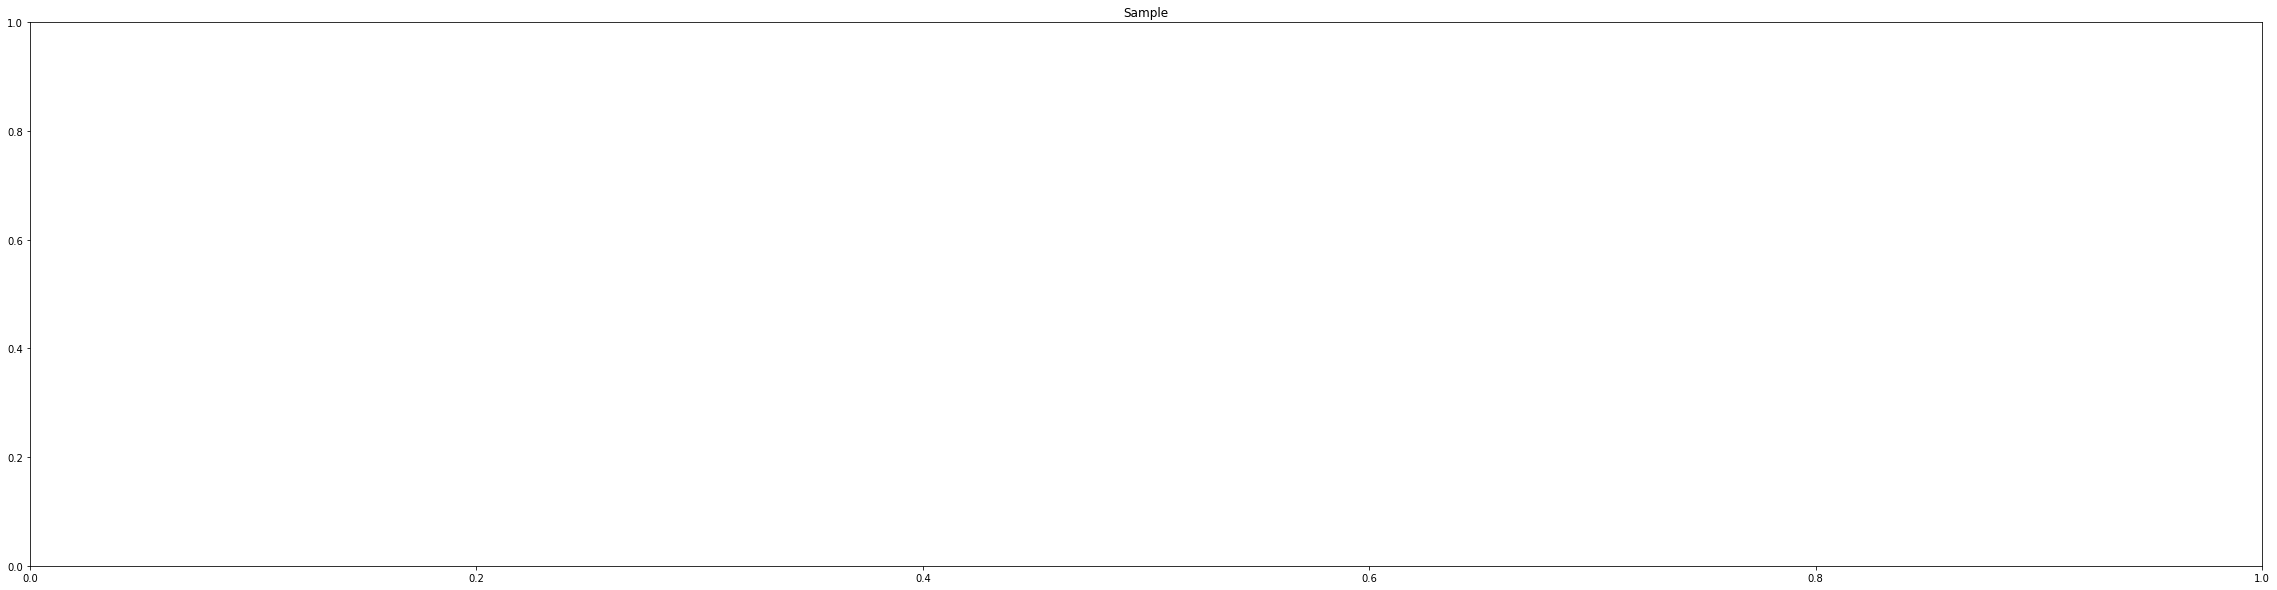

In [5]:
sample_x = None
sample_y = None

for x, y in dataset_validation.take(1):
    print("here")
    sample_x = x.numpy()
    sample_y = y.numpy()

plt.figure(figsize=(40,10))
plt.title("Sample")
plt.plot(sample_x)
plt.show()

print(sample_x)